In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from config import api_key
from census import Census
from us import states

## Defining three functions:
* census_data(year): return census data of that year.
* vote_data(year): return vote data of that year.
* get_dataset(year): merge census and vote data, clean and format them.
* Example usage: data_2016 = get_dataset(2016)

In [2]:
# census_api() function, returning the census data of a given year.
def census_data(YEAR):
    c = Census(api_key, year=YEAR)
    raw_data = c.acs5.get(('NAME', 'B19013_001E', 'B19301_001E', 'B23025_003E',
                       'B23025_004E', 'B23025_005E', 'B01003_001E', "B01002_001E", "B17001_002E",'B01002_002E','B01002_003E',
                          'B02001_002E', 'B02001_003E', 'B02001_005E','B03001_003E','B02001_004E','B25035_001E'), {'for':'state:*'})
    census_df_raw = pd.DataFrame(raw_data)
    census_df_raw = census_df_raw.rename(columns = {'state': 'State#',
                          'NAME': 'State', 
                          'B01003_001E':'Total_population',
                          'B23025_003E':'Employable_civilians',
                          'B23025_004E':'Employed_civilians', 
                          'B23025_005E':'Unemployed_civilians', 
                          'B19013_001E':'Income_median',
                          'B19301_001E':'Income_per_capita',
                          "B01002_001E":'median age',
                          "B17001_002E":'Poverty_count',
                          'B01002_002E':'median_male_age',
                          'B01002_003E':'median_female_age',
                          'B02001_002E':'population_white_alone',
                          'B02001_003E':'population_black_alone',
                          'B02001_005E':'population_asian_alone',
                          'B03001_003E':'population_hispanic_origin',
                          'B02001_004E':'population_american_indian_alone',
                          'B25035_001E':'median_house_construction_year'                         
                                            
    })
    census_df_raw = census_df_raw.sort_values('State#').reset_index(drop=True)
    # reformatting census data
    census_df = census_df_raw.loc[:,['State', 'Total_population', 'Income_median', 'Income_per_capita','median_male_age','median_female_age',
                                    'population_white_alone','population_black_alone', 'population_asian_alone','population_hispanic_origin',
                                    'population_american_indian_alone', 'median_house_construction_year']]
    census_df['Poverty_rate'] = census_df_raw.Poverty_count/census_df_raw.Total_population
    census_df['Unemployment_rate'] = census_df_raw.Unemployed_civilians/census_df_raw.Employable_civilians
    state_df = pd.read_csv('Resources/state_centroids.csv')
    census_df = pd.merge(census_df, state_df, on = 'State')
    census_df = census_df.set_index('State')
    return census_df

In [3]:
# Preparing the vote data of a given year.
csvfile = 'Resources/1976-2016-president.tab'
vote_df = pd.read_csv(csvfile, sep='\t', header=(0))
# Fixing the party label for 2012 minnesota democrat votes
vote_df = vote_df.replace('democratic-farmer-labor', 'democrat')

In [4]:
def vote_data(YEAR):
    demo_raw = vote_df.loc[(vote_df.year == YEAR)&(vote_df.party == 'democrat'), ['state', 'candidatevotes']]
    demo = demo_raw.groupby('state')['candidatevotes'].sum()
    rep_raw = vote_df.loc[(vote_df.year == YEAR)&(vote_df.party == 'republican'),['state', 'candidatevotes']]
    rep = rep_raw.groupby('state')['candidatevotes'].sum()
    total = vote_df.loc[(vote_df.year == YEAR), ['state', 'totalvotes']].groupby('state').mean()['totalvotes'] 
    vote_df_year = pd.concat([demo, rep, total],axis=1)
    vote_df_year.columns = [str(YEAR)+'_democrat_votes', str(YEAR)+'_republican_votes', str(YEAR)+'_total_votes']
    return vote_df_year

In [5]:
# Merging data for a given year. The function takes 3 arguments: dataframe1, dataframe2, year
def get_dataset(YEAR):
    dataset = census_data(YEAR).merge(vote_data(YEAR), left_index=True, right_index=True)
    dataset['votes difference'] = dataset[str(YEAR)+'_democrat_votes'] - dataset[str(YEAR)+'_republican_votes']
    dataset.loc[dataset['votes difference']<0, 'winner'] = 'Republican'
    dataset.loc[dataset['votes difference']>0, 'winner'] = 'Democrat'
    return dataset

In [6]:
data_2016 = get_dataset(2016)
data_2012 = get_dataset(2012)

In [7]:
data_2016.head(3)

,Total_population,Income_median,Income_per_capita,median_male_age,median_female_age,population_white_alone,population_black_alone,population_asian_alone,population_hispanic_origin,population_american_indian_alone,median_house_construction_year,Poverty_rate,Unemployment_rate,Latitude,Longitude,2016_democrat_votes,2016_republican_votes,2016_total_votes,votes difference,winner
Alabama,4841164.0,44758.0,24736.0,37.1,40.0,3325037.0,1282053.0,60744.0,193503.0,23919.0,1982.0,0.179433,0.082856,32.7794,-86.8287,729547,1318255,2123372,-588708,Republican
Alaska,736855.0,74444.0,34191.0,33.3,34.0,483518.0,24443.0,44218.0,49031.0,103574.0,1984.0,0.098834,0.078468,64.0685,-152.2782,116454,163387,318608,-46933,Republican
Arizona,6728577.0,51340.0,26686.0,35.8,38.4,5235158.0,287110.0,205229.0,2054849.0,296732.0,1989.0,0.173237,0.079880,34.2744,-111.6602,1161209,1252401,2573165,-91192,Republican


# training data 2016

In [10]:
X = data_2016[['Total_population', 'Income_median', 'Income_per_capita', 'Unemployment_rate',
               'Poverty_rate', 'Latitude', 'Longitude', 'median_male_age','median_female_age',
              'population_white_alone','population_black_alone', 'population_asian_alone',
               'population_hispanic_origin', 'population_american_indian_alone', 
               'median_house_construction_year']]
y = data_2016['winner']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 5)

* training decision_tree classifier

In [11]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train,y_train)
feature_importances = pd.DataFrame(decision_tree.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
Income_per_capita,0.618844
Latitude,0.184889
Longitude,0.094044
population_black_alone,0.053333
Poverty_rate,0.048889
Total_population,0.000000
Income_median,0.000000
Unemployment_rate,0.000000
median_male_age,0.000000
median_female_age,0.000000


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

In [13]:
# y_predict_train = decision_tree.predict(X_train)
# y_predict_train
# cm = confusion_matrix(y_train, y_predict_train)
# sns.heatmap(cm, annot=True)

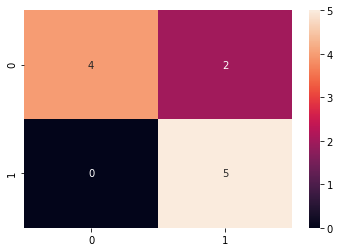

In [14]:
y_predict_test = decision_tree.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True)

In [ ]:
# print(classification_report(y_test, y_predict_test))

# decision tree 2012 data
* X_2012, y_2012, y_predict_test_2012

In [17]:
X_2012 = data_2012[['Total_population', 'Income_median', 'Income_per_capita', 'Unemployment_rate',
               'Poverty_rate', 'Latitude', 'Longitude', 'median_male_age','median_female_age',
              'population_white_alone','population_black_alone', 'population_asian_alone',
               'population_hispanic_origin', 'population_american_indian_alone', 
               'median_house_construction_year']]
y_2012 = data_2012['winner']

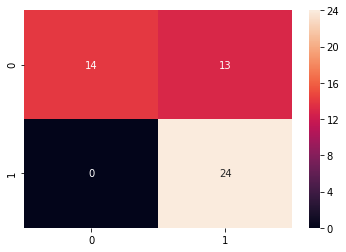

In [18]:
y_predict_test_2012 = decision_tree.predict(X_2012)
# y_predict_test_2012
cm_2012 = confusion_matrix(y_2012, y_predict_test_2012)
sns.heatmap(cm_2012, annot=True)

# RandomForest classifier
* rf_model

In [19]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [20]:
# y_predict_train = rf_model.predict(X_train)
# y_predict_train
# cm = confusion_matrix(y_train, y_predict_train)
# sns.heatmap(cm, annot=True)

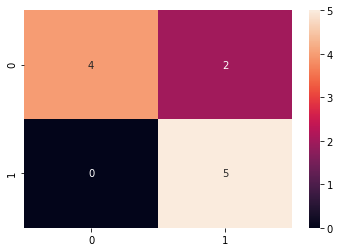

In [21]:
y_predict_test = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True)

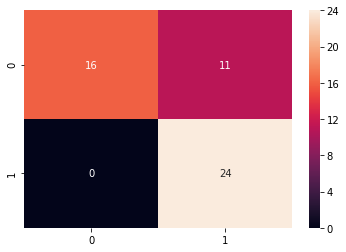

In [22]:
y_predict_rf_2012 = rf_model.predict(X_2012)
cm = confusion_matrix(y_2012, y_predict_rf_2012)
sns.heatmap(cm, annot=True)

In [23]:
# data_2012['prediction'] = y_predict_rf_2012
# data_2012[['winner','prediction']]

# master_df

In [24]:
data_2012_2016 = pd.concat([data_2012.reset_index(), data_2016.reset_index()], ignore_index=True, axis=0)
data_2012_2016

C:\Users\zhan3\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,2012_democrat_votes,2012_republican_votes,2012_total_votes,2016_democrat_votes,2016_republican_votes,2016_total_votes,Income_median,Income_per_capita,Latitude,Longitude,...,median_female_age,median_house_construction_year,median_male_age,population_american_indian_alone,population_asian_alone,population_black_alone,population_hispanic_origin,population_white_alone,votes difference,winner
0,795696.0,1255925.0,2074338.0,NaN,NaN,NaN,43160.0,23587.0,32.7794,-86.8287,...,39.2,1980.0,36.4,26166.0,54923.0,1256097.0,182268.0,3321318.0,-460229,Republican
1,122640.0,164676.0,300495.0,NaN,NaN,NaN,69917.0,32537.0,64.0685,-152.2782,...,34.0,1982.0,33.6,98976.0,37968.0,24219.0,40371.0,477985.0,-42036,Republican
2,1025232.0,1233654.0,2299254.0,NaN,NaN,NaN,50256.0,25571.0,34.2744,-111.6602,...,37.2,1988.0,34.8,283805.0,177598.0,262284.0,1902946.0,5085954.0,-208422,Republican
3,394409.0,647744.0,1069468.0,NaN,NaN,NaN,40531.0,22007.0,34.8938,-92.4426,...,38.7,1981.0,36.1,17390.0,35744.0,453062.0,185239.0,2285577.0,-253335,Republican
4,7854285.0,4839958.0,13038547.0,NaN,NaN,NaN,61400.0,29551.0,37.1841,-119.4696,...,36.4,1973.0,34.1,291505.0,4921543.0,2254160.0,14024109.0,23252553.0,3014327,Democrat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,NaN,NaN,NaN,1981473.0,1769443.0,3982752.0,66149.0,34967.0,37.5215,-78.8537,...,39.1,1981.0,36.5,21948.0,502878.0,1596352.0,725092.0,5712958.0,212030,Democrat
98,NaN,NaN,NaN,1742718.0,1221747.0,3317019.0,62848.0,32999.0,47.3826,-120.4472,...,38.6,1980.0,36.6,94026.0,552032.0,256990.0,854275.0,5470566.0,520971,Democrat
99,NaN,NaN,NaN,188794.0,489371.0,713051.0,42644.0,24002.0,38.6409,-80.6227,...,43.1,1974.0,40.7,3281.0,13990.0,63305.0,26247.0,1725411.0,-300577,Republican
100,NaN,NaN,NaN,1382536.0,1405284.0,2976150.0,54610.0,29253.0,44.6243,-89.9941,...,40.3,1972.0,38.0,51459.0,148077.0,361730.0,371205.0,4961193.0,-22748,Republican


In [38]:
X = data_2012_2016[['Total_population', 'Income_median', 'Income_per_capita', 'Unemployment_rate',
               'Poverty_rate', 'Latitude', 'Longitude', 'median_male_age','median_female_age',
              'population_white_alone','population_black_alone', 'population_asian_alone',
               'population_hispanic_origin', 'population_american_indian_alone', 
               'median_house_construction_year']]
y = data_2012_2016['winner']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 5)

* training decision_tree classifier

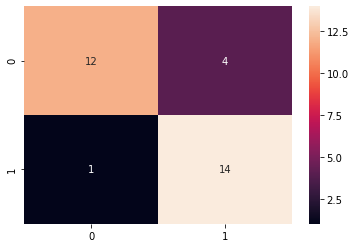

In [39]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train,y_train)
feature_importances = pd.DataFrame(decision_tree.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

from sklearn.metrics import classification_report, confusion_matrix

# y_predict_train = decision_tree.predict(X_train)
# y_predict_train
# cm = confusion_matrix(y_train, y_predict_train)
# sns.heatmap(cm, annot=True)

y_predict_test = decision_tree.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True)

In [29]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

    Democrat       0.81      0.81      0.81        16
  Republican       0.80      0.80      0.80        15

    accuracy                           0.81        31
   macro avg       0.81      0.81      0.81        31
weighted avg       0.81      0.81      0.81        31



* Training randomforest classifier

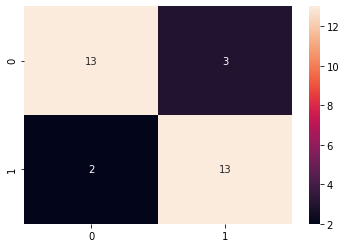

In [40]:
from sklearn.ensemble import RandomForestClassifier
rf_model_master = RandomForestClassifier(n_estimators=100)
rf_model_master.fit(X_train, y_train)
y_predict_test_master = rf_model_master.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test_master)
sns.heatmap(cm, annot=True)

# Data visualization